Workbench for processing a video file and finding the frames where 
the red light is on, as well as positioning the randomly flashing LED
used for aligning with the logged data.  

The output of this is a pandas dataframe of the on and off lights
which can be merged with the log data to find the (m*framenumber + c) -> time

There is an interactive panel for working out the basic 

In [1]:
videoFile = "/home/julian/repositories/Future-Hangglider/hangspotdetection/vidprocessing/10380001.MOV"


In [2]:
import cv2
cap = cv2.VideoCapture(videoFile)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
ret, f = cap.read()
fheight, fwidth = f.shape[:2]
print("width %d  height %d  frames %d  time %f seconds" % (fwidth, fheight, total_frames, total_frames/30))


width 1920  height 1080  frames 13950  time 465.000000 seconds


In [3]:
#
# Use this section to zoom in on the place where the LED is (and find the inrange)
#
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import ipywidgets as widgets
from ipywidgets import HBox, VBox, IntSlider, Label, Button, Checkbox, Layout
from IPython.display import display

In [4]:
#
# The plotting, preview and external settings
#
frame = None
disableplotfigure = False
histrec = None

def settvalues(fxpos, fypos, fxywidth, chan1pos, chan2pos, chan3pos, chanwidth):
    # compatible with fdefaults
    trimvs = [fypos, fypos+fxywidth, fxpos, fxpos+fxywidth]
    tinRange = [(max(0,chan1pos-chanwidth), max(0,chan2pos-chanwidth), max(0,chan3pos-chanwidth)), 
                (min(255,chan1pos+chanwidth), min(255,chan2pos+chanwidth), min(255,chan3pos+chanwidth))]
    return trimvs, tinRange

def plotfigure(framepos, fxpos, fypos, fxywidth, bhsv, btrim, bmask, 
               chan1pos, chan2pos, chan3pos, chanwidth):
    global frame, histrec
    if disableplotfigure:
        return
    trimvs, tinRange = settvalues(fxpos, fypos, fxywidth, chan1pos, chan2pos, chan3pos, chanwidth)
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, framepos-1)
    ret, frame = cap.read()
    tframe = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV if bhsv else cv2.COLOR_BGR2RGB)
    subtframe = tframe[trimvs[0]:trimvs[1],trimvs[2]:trimvs[3]]
    
    if btrim:
        histdata = subtframe.reshape(-1,3).transpose()
        if bmask:
            shownframe = cv2.inRange(subtframe, tinRange[0], tinRange[1])
            print("Mask size %d of %d" % (shownframe.sum()/255, shownframe.shape[0]*shownframe.shape[1]))
        else:
            shownframe = subtframe
    else:
        histdata = tframe.reshape(-1,3).transpose()
        if bmask:
            shownframe = cv2.inRange(tframe, tinRange[0], tinRange[1])
        else:
            shownframe = tframe
            shownframe[fypos:fypos+fxywidth,fxpos:fxpos+fxywidth] = [0,255,0]
        
    #plt.scatter([fxpos], [fypos], color="red")
    fig = plt.figure(figsize=(11,5))
    fig.add_subplot(121)
    plt.imshow(shownframe)
    fig.add_subplot(122)
    histrec = plt.hist(list(histdata), 20, width=1)
    plt.scatter([tinRange[0][0],tinRange[1][0]], [0,0], color="blue")
    plt.scatter([tinRange[0][1],tinRange[1][1]], [0,0], color="orange")
    plt.scatter([tinRange[0][2],tinRange[1][2]], [0,0], color="green")
    


In [5]:
#
# define all the components
#
framepos = IntSlider(min=1, max=total_frames, continuous_update=False)
wplus = Button(description='>')
wminus = Button(description='<')
bcentrechannel = Button(description="ccent")

fxpos = IntSlider(min=1, max=fwidth, continuous_update=False)
fypos = IntSlider(min=1, max=fheight, continuous_update=False)
fxywidth = IntSlider(min=1, max=300, continuous_update=False)
cbhsv = Checkbox(description="hsv", indent=False, value=False)
cbtrim = Checkbox(description="trim", indent=False, value=False)
cbmask = Checkbox(description="mask", indent=False, value=False)
cbspot = Checkbox(description="spot", indent=False, value=False)

chan1pos = IntSlider(min=1, max=255, continuous_update=False)
chan2pos = IntSlider(min=1, max=255, continuous_update=False)
chan3pos = IntSlider(min=1, max=255, continuous_update=False)
chanwidth = IntSlider(min=1, max=50, continuous_update=False)


In [6]:
#
# Locally activate the components
#

def wpickoffs(n):  
    framepos.value += n
wplus.on_click(lambda name: wpickoffs(1))
wminus.on_click(lambda name: wpickoffs(-1))

# initiate the setups
fdefaults = [[1554, 657, 100, 0, 0, 255, 11], 
             [500, 700, 20, 50, 50, 50, 10]]
fvlist = [fxpos, fypos, fxywidth, chan1pos, chan2pos, chan3pos, chanwidth]

def recsetsliderdefaults(c):
    global disableplotfigure
    if 'old' in c:
        for i, fv in enumerate(fvlist):
            fdefaults[int(c["old"])][i] = fv.__getattribute__("value")
    if 'new' in c:
        disableplotfigure = True  # hack to stop updating pic while we update values
        for i, fv in enumerate(fvlist):
            disableplotfigure = (i != len(fvlist)-1)
            fv.__setattr__("value", fdefaults[int(c["new"])][i])
cbspot.observe(recsetsliderdefaults, names="value")
recsetsliderdefaults({"new":False})

def centrechannel(c):
    for i, chv, ch in zip(range(3), [chan1pos, chan2pos, chan3pos], histrec[0]):
        disableplotfigure = (i != 2)
        mxc = max(zip(ch, histrec[1]))
        print(i, mxc)
        chv.__setattr__("value", int(mxc[1]))
bcentrechannel.on_click(centrechannel)


In [7]:

chanbox = VBox([HBox([Label("c1"), chan1pos]), 
                HBox([Label("c2"), chan2pos]), 
                HBox([Label("c3"), chan3pos]), 
                HBox([Label("cw"), chanwidth])])

# handle the layout
wplus.layout.width = "25px"
wminus.layout.width = "25px"
cbhsv.layout.width = "50px"
cbtrim.layout.width = "50px"
cbmask.layout.width = "50px"
cbspot.layout.width = "50px"
bcentrechannel.layout.width = "60px"

framebox = VBox([HBox([cbhsv, cbtrim, cbmask, cbspot, bcentrechannel]),
                 chanbox])

fxyrbox = VBox([HBox([Label("frame"), wplus, wminus, framepos]),
             HBox([Label("x"), fxpos]), 
             HBox([Label("y"), fypos]), 
             HBox([Label("r"), fxywidth])])

uibox = HBox([fxyrbox, framebox])

params = {'framepos': framepos, "fxpos":fxpos, "fypos":fypos, 
          "fxywidth":fxywidth, "bhsv":cbhsv, "btrim":cbtrim, "bmask":cbmask, 
          "chan1pos":chan1pos, "chan2pos":chan2pos, "chan3pos":chan3pos, "chanwidth":chanwidth
         }
outputfigure = widgets.interactive_output(plotfigure, params)
outputfigure.layout.height = '400px'
display(uibox, outputfigure);

# should do plotting of ellipse on untrimmed mask

Output(layout=Layout(height='400px'))

In [8]:
#
# run this to find LED frames in dataset in isolation
#

ledwashoutthreshold = 10000
recsetsliderdefaults({"old":cbspot.value}) # store the numbers

# run this to find the ledwashout threshold for your select area
def ledwashoutcount(frame):
    trimvs, tinRange = settvalues(*fdefaults[0])
    v = frame[trimvs[0]:trimvs[1],trimvs[2]:trimvs[3]]
    fh = cv2.cvtColor(v, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(fh, tinRange[0], tinRange[1])
    return mask.sum()/255

def frameledwashout(fn):
    cap.set(cv2.CAP_PROP_POS_FRAMES, fn-1)
    ret, frame = cap.read()
    sm = ledwashoutcount(frame)
    return sm>ledwashoutthreshold

frameskip = 10
bledon0 = False
fn = 0
fncol, fvcol = [ ], [ ]
while fn < total_frames - frameskip:
    fn += frameskip
    bledon = frameledwashout(fn)
    if bledon != bledon0:
        for fnb in range(fn-1, fn-frameskip, -1):
            bledonb = frameledwashout(fnb)
            if bledonb != bledon:
                fnb += 1
                break
        fncol.append(fnb)
        fvcol.append(bledon)
        if (len(fncol)%10) == 0:
            print(len(fncol), fncol[-1])
        bledon0 = bledon

rdfv = pandas.DataFrame({"fn":fncol, "fv":fvcol})
    

10 1156
20 2355


KeyboardInterrupt: 

In [4]:
# Can we automate finding the right range and tracking the ball through
# several iterations getting cleaner and cleaner values

In [36]:
# 
# Run this to make the chart for all the hangspot and the led
# 
recsetsliderdefaults({"old":cbspot.value}) # store the numbers

def ellipspos(frame):
    trimvs, tinRange = settvalues(*fdefaults[1])
    tframe = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(tframe, tinRange[0], tinRange[1])
    contours, hierarchy = cv2.findContours(mask, 1, 2)[1:]
    ellipses = [cv2.fitEllipse(cnt)  for cnt in contours  if len(cnt) > 5 and cv2.contourArea(cnt)]
    ellipses.sort(key=lambda X:X[0][0])
    if len(ellipses) == 0:
        return (np.nan, np.nan)
    return ellipses[0][0]

smcol, elxcol, elycol = [ ], [ ], [ ]
fn = 0
cap.set(cv2.CAP_PROP_POS_FRAMES, fn)
while True:
    ret, frame = cap.read()
    fn += 1
    if not ret:
        break
    sm = ledwashoutcount(frame)
    elx, ely = ellipspos(frame)
    smcol.append(sm)
    elxcol.append(elx)
    elycol.append(ely)
    if (fn%1000) == 0:
        print("frame", fn, sm, elx, ely)

dfrel = pandas.DataFrame({"sm":smcol, "elx":elxcol, "ely":elycol})
dfrel.to_csv("hangspot.csv")


frame 1000 0.0 355.29400634765625 365.4029541015625
frame 2000 65.0 1057.197998046875 678.0662231445312
frame 3000 189.0 347.0691833496094 1030.7691650390625
frame 4000 101.0 274.53253173828125 809.9915161132812
frame 5000 0.0 936.351318359375 571.2045288085938
frame 6000 0.0 371.2327575683594 302.91815185546875
frame 7000 0.0 940.2382202148438 567.7078857421875
frame 8000 0.0 357.16552734375 341.1468811035156
frame 9000 405.0 nan nan
frame 10000 0.0 126.02491760253906 482.89898681640625
frame 11000 0.0 831.740478515625 877.0
frame 12000 0.0 nan nan
frame 13000 0.0 1371.7847900390625 588.8397827148438


In [42]:
dfrel.to_csv("hangspot.csv", index_label="fn")

In [370]:
#
# Now load in the file with the logging data in it
#
import pandas, numpy, matplotlib
import sys
sys.path.append("../../hacktrack")
from hacktrack import loaders
fname = "udpstream.log"
fname = "/home/julian/repositories/Future-Hangglider/hangspotdetection/vidprocessing/hdata-2018-11-20_18-41-45.log"
fd = loaders.FlyDat(fname)
fd.LoadC("U")

Setting knowndate 2018-11-20
should be same 2018-11-20 00:00:00 2018-11-20 00:00:00
badline End(79319,12412)

F:28296, V:1, Z:50884, U:138, aZ:9480, aF:2931
linAdifftime -110497.84479895105 count 11440
Made for Q 0 last index 0
Made for V 1 last index 1
Warning, using guessed (not GPS) timing corrected value on V 1
timeflightindexerror
Made for U 138 last index 138
Warning, using guessed (not GPS) timing corrected value on U 138


In [371]:
rdfv = pandas.DataFrame({"fn":[r[1]  for r in res], "fv":[1 if r[0] else 0  for r in res]})

In [372]:
#
# process the LED flashing logging data to align with records
#
def makedfpon(rdf):
    ron, roff = list(rdf.fn[rdf.fv == 1]), list(rdf.fn[rdf.fv == 0])
    df = pandas.DataFrame({"ron":ron, "roff":roff})
    df["dron"] = df.roff - df.ron
    df["droff"] = df.ron.shift(-1) - df.roff
    df["pon"]= df["dron"]/df["droff"]
    df["i"] = list(range(len(df.pon)))
    return df

dfvid = makedfpon(rdfv)

t0 = fd.pU.index[0]
fd.pU["fn"] = (fd.pU.index.to_series() - t0)/pandas.Timedelta(seconds=1)
fd.pU["fv"] = fd.pU.Dust

dflog = makedfpon(fd.pU)



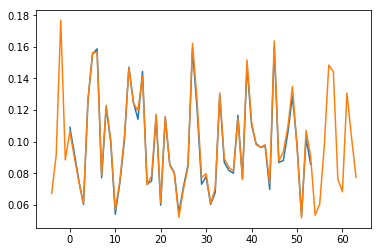

In [389]:
# plot with offsets to find the best alignment
plt.plot(dfvid.i, dfvid.pon)
plt.plot(dflog.i-4, dflog.pon)

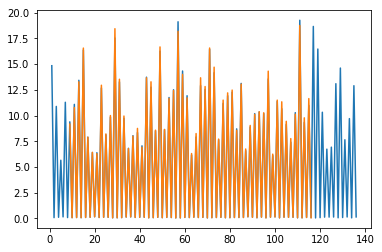

In [393]:
k = fd.pU.fn.diff(1).shift(-1).values/fd.pU.fn.diff(1).values
k1 = rdfv.fn.diff(1).shift(-1).values/rdfv.fn.diff(1).values
koffs = 8
plt.plot(k)
plt.plot(list(range(koffs, koffs+len(k1))), k1)


In [396]:
koffs

8

0.03333138717693325 33.009084222785795


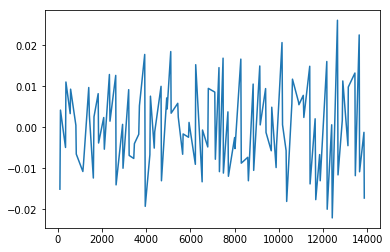

In [402]:
#
# Now line up the matching values to get the (mframe*fn+cframe)+t0 transform
#
koffs = 8
rdfv["tmatch"] = numpy.nan
for i in range(len(fd.pU)):
    ii = i - koffs
    if 0 <= ii < len(rdfv):
        rdfv.loc[ii,"tmatch"] = fd.pU.fn.iloc[i]
#fd.pU.fn
#rdfv
r = rdfv.dropna()
#plt.plot(r.fn, r.tmatch)

mframe, cframe = numpy.polyfit(r.fn, r.tmatch, 1)
print(mframe, cframe)
plt.plot(rdfv.fn, rdfv.fn*mframe + cframe - rdfv.tmatch)
# (might need to pull this back half a frame to get this to be right, or keep only the on-position to centre it)


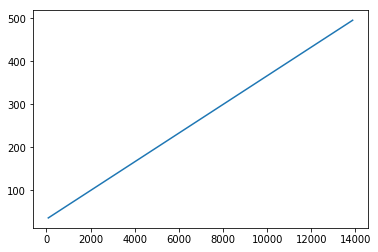

In [401]:
plt.plot(r.fn, r.tmatch)

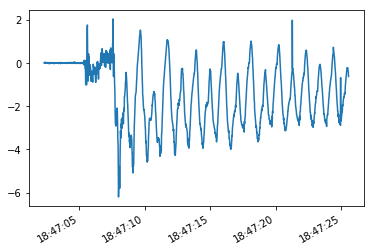

In [419]:
#fd.pZ.roll.iloc[27000:29000].plot()
fd.pZ.az.iloc[27000:29000].plot()


In [294]:
import cv2
import math

#capgen = Capgen(videoFile)
import numpy
kernel = numpy.ones((5,5),numpy.uint8)

def yellowspot(f):
    fb = cv2.GaussianBlur(f, (11,11), 0)
    fh = cv2.cvtColor(fb, cv2.COLOR_BGR2HSV)
    fh[:,:,0] = (fh[:,:,0]+25)%180 
    ht = 50
    hr = 5
    mask = cv2.inRange(fh, (ht-hr,200,20), (ht+hr,256,256))
    mask = cv2.erode(mask,kernel,iterations = 2)
    #plt.imshow(mask)
    contours, hierarchy = cv2.findContours(mask, 1, 2)[1:]
    ellipses = [cv2.fitEllipse(cnt)  for cnt in contours  if cv2.contourArea(cnt)>800]
    cy, cx = 280, 700
    ellipses.sort(key=lambda X:abs(X[0][0]-cy)+abs(X[0][1]-cx))
    return ellipses, mask

if 0:
    n, cf = skiptoframe(474)
    f = cf.copy()
    res = yellowspot(f)
    print(res[0])
    plt.figure(figsize=(12,12))
    cv2.ellipse(f, res[0][0],(0,255,0),2)
    plt.imshow(res[1])
    plt.imshow(cv2.cvtColor(f, cv2.COLOR_BGR2RGB))
    n


In [222]:
res = yellowspot(cf.copy())
res[0]

[((776.3525390625, 140.0251007080078),
  (17.154775619506836, 62.72624206542969),
  91.37940979003906),
 ((354.3440246582031, 552.2646484375),
  (63.89350128173828, 90.59012603759766),
  9.058860778808594)]

In [ ]:
cv2.contourArea(cnt)

In [295]:
ellipses = yellowspot(capgen.f)[0]
ellipses

[((329.94598388671875, 536.7793579101562),
  (67.3471450805664, 89.4089126586914),
  10.355764389038086),
 ((781.9375, 136.78750610351562),
  (18.679746627807617, 68.77940368652344),
  95.24168395996094)]

In [293]:
cy, cx = 280, 700
list(map(lambda X:abs(X[0][0]-cy)+abs(X[0][1]-cx), ellipses))
#ellipses

[1065.1499938964844, 213.1666259765625]

[(((329.94598388671875, 536.7793579101562), (67.3471450805664, 89.4089126586914), 10.355764389038086), 4394.5), (((781.9375, 136.78750610351562), (18.679746627807617, 68.77940368652344), 95.24168395996094), 839.5)]


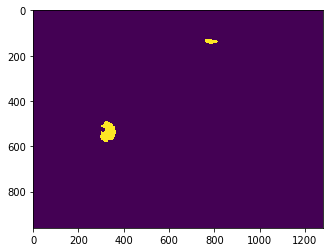

In [289]:
cf = capgen.frame(479)
fb = cv2.GaussianBlur(cf.copy(), (11,11), 0)
fh = cv2.cvtColor(fb, cv2.COLOR_BGR2HSV)
fh[:,:,0] = (fh[:,:,0]+25)%180 
ht = 50
hr = 5
mask = cv2.inRange(fh, (ht-hr,200,20), (ht+hr,256,256))
mask = cv2.erode(mask,kernel,iterations = 2)
plt.imshow(mask)
contours, hierarchy = cv2.findContours(mask, 1, 2)[1:]
ellipses = [(cv2.fitEllipse(cnt), cv2.contourArea(cnt))  for cnt in contours  if cv2.contourArea(cnt)>800]
cy, cx = 700, 480
#ellipses.sort(key=lambda X:abs(X[0][0]-cy)+abs(X[0][1]-cx))
print(ellipses)


In [296]:
capgen = Capgen(videoFile)
yellspots = [ ]
while True:
    n, f = capgen.nextframe()
    if f is None:
        break
    res = yellowspot(f)
    p = res[0][0][0]
    yellspots.append((n, p[0], p[1]))
    if (n%100)==0:
        print(n)

100
200
300
400
500
600
700
800
900
1000
1000
1100
1200
1300
1400


(474, 358.12774658203125, 551.7518920898438)

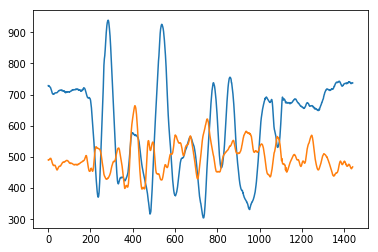

In [297]:
lyellspots = yellspots[470:480]
lyellspots = yellspots

plt.plot([y[0]  for y in lyellspots], [y[1]  for y in lyellspots])
plt.plot([y[0]  for y in lyellspots], [y[2]  for y in lyellspots])
yellspots[473]

In [308]:
import csv
w = csv.writer(open("GOPR3497conv.csv", "w"))
w.writerow(("n","x","y"))
for l in yellspots:
    w.writerow(l)
del w